In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchinfo import summary

def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct/len(y_pred)*100

device = "cuda" if torch.cuda.is_available() else "cpu"


# Label encoding for genders and plurality
gender_to_idx = {"masculine": 0, "feminine": 1, "neutral": 2}

# Der die das to idx:
artikel_to_idx = {"der": 0, "die": 1, "das": 2}

In [8]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
# Replace 'your_file.txt' with the name of your file
file_path = 'words_small.txt'
file_path_2 = 'words_big.txt'

data = []

"""# Read and split lines
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        columns = line.split()
        if len(columns) >= 4:
            data.append([artikel_to_idx[columns[2].lower()], columns[3].lower()])
            try:
                if "(" not in columns[4] and random.randint(0, 2) == 1:
                    data.append([3, columns[5].lower()])
            except IndexError:
                pass
"""

with open(file_path_2, 'r') as file:
    for line in file:
        word, numbers = line.split(maxsplit=1)
        num1, num2, num3 = map(int, numbers.split(','))

        if num1 != 0:
            data.append([0, word])
        if num2 != 0:
            data.append([1, word])
        if num3 != 0:
            data.append([2, word])

data = data[:len(data)//4]

data_train, data_test = train_test_split(data, test_size=0.2)

counts = [0, 0, 0]
for i in data:
    counts[i[0]] += 1

counts

[27831, 35956, 17788]

In [10]:
class GermanNounDataset(Dataset):
    def __init__(self, data, char_to_idx):
        self.data = data
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        index, word = self.data[idx]
        # Convert word to character indices
        word_indices = [self.char_to_idx[char] for char in word]
        
        return torch.tensor(word_indices, dtype=torch.long), index

# Create character to index mapping
chars = set("".join([word for _, word in data]))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
char_to_idx['<pad>'] = 0  # Padding token

# Initialize dataset and DataLoader
train_dataset = GermanNounDataset(data_train, char_to_idx)
test_dataset = GermanNounDataset(data_test, char_to_idx)

test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=lambda x: collate_fn(x))
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=lambda x: collate_fn(x))

# Collate function to pad sequences
def collate_fn(batch):
    words, indices = zip(*batch)
    max_len = max(len(w) for w in words)
    padded_words = torch.zeros(len(words), max_len, dtype=torch.long)
    
    for i, word in enumerate(words):
        padded_words[i, :len(word)] = word

    return padded_words, torch.tensor(indices)

In [11]:
import torch.nn as nn

class ArtikelTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers):
        super(ArtikelTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.zeros(1, 100, embedding_dim))  # Assuming max length of 100
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_indices = nn.Linear(embedding_dim, 4)

    def forward(self, x):
        seq_len = x.size(1)
        pos_embedded = self.pos_embedding[:, :seq_len, :]
        embedded = self.embedding(x) + pos_embedded
        transformer_out = self.transformer(embedded)
        pooled_out = transformer_out.mean(dim=1)
        return self.fc_indices(pooled_out)

class ArtikelClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, num_layers):
        super(ArtikelClassifier, self).__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout, bidirectional=True, num_layers=num_layers)
        
        self.indices_fc = nn.Sequential(nn.Linear(2*hidden_dim*num_layers, 3),
                                       )

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = hidden.squeeze(0)
        hidden = torch.cat(tuple([hidden[i] for i in range(2*self.num_layers)]), dim=1)
        #hidden = hidden.squeeze(0)

        indices_output = self.indices_fc(hidden)

        return indices_output

# Initialize the model
vocab_size = len(char_to_idx)
embedding_dim = 8
hidden_dim = 16
num_filters = 16
num_heads = 8
num_layers = 4
model = ArtikelClassifier(vocab_size, embedding_dim=32, hidden_dim=8, dropout=0.8, num_layers=1)
#model = ArtikelTransformer(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers).to(device)
model.to(device)

summary(model, input_size=(1, 10), dtypes=[torch.long], col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

C:\Users\Tomek\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ArtikelClassifier (ArtikelClassifier)    [1, 10]              [1, 3]               --                   True
├─Embedding (embedding)                  [1, 10]              [1, 10, 32]          992                  True
├─LSTM (lstm)                            [1, 10, 32]          [1, 10, 16]          2,688                True
├─Sequential (indices_fc)                [1, 16]              [1, 3]               --                   True
│    └─Linear (0)                        [1, 16]              [1, 3]               51                   True
Total params: 3,731
Trainable params: 3,731
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
test_accuracies = []

In [13]:
# Training loop
for epoch in range(5):  # Number of epochs
    train_loss = 0
    model.train()
    for words, indices in train_dataloader:
        optimizer.zero_grad()

        # Forward pass
        indices_output = model(words.to(device))

        # Calculate loss
        loss = F.cross_entropy(indices_output, indices.to(device))
        train_loss += loss

        # Combine the losses
        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss.cpu().detach().numpy())

    test_loss = 0
    test_accuracy = 0
    with torch.inference_mode():
        for words, indices in test_dataloader:
            # Forward pass
            indices_output = model(words.to(device))
    
            # Calculate loss
            test_loss += F.cross_entropy(indices_output, indices.to(device))
            test_accuracy += accuracy(indices, indices_output.argmax(dim=1).cpu())

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss.cpu())

        test_accuracy /= len(test_dataloader)
        test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}, Train_loss: {train_loss.item():.4f}, Test_loss: {test_loss.item():.4f}, Accuracy: {test_accuracy:.4f}")

Epoch 1, Train_loss: 0.8600, Test_loss: 0.7163, Accuracy: 69.0353
Epoch 2, Train_loss: 0.7131, Test_loss: 0.7010, Accuracy: 69.3350
Epoch 3, Train_loss: 0.6794, Test_loss: 0.6433, Accuracy: 74.0680
Epoch 4, Train_loss: 0.6313, Test_loss: 0.6270, Accuracy: 74.7660
Epoch 5, Train_loss: 0.6020, Test_loss: 0.5853, Accuracy: 78.0754


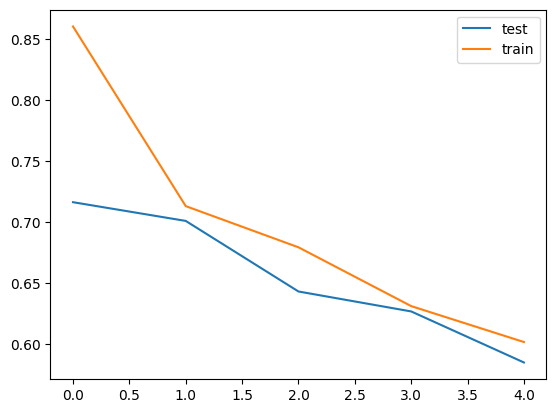

In [14]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

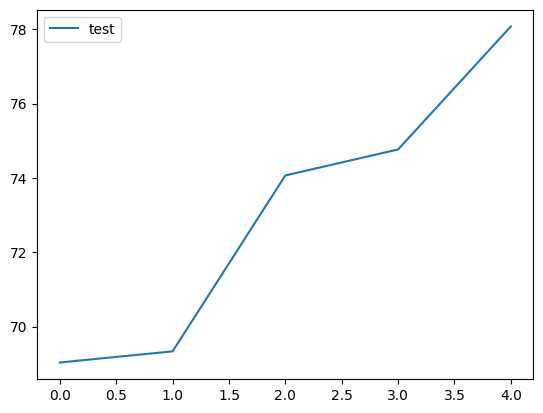

In [15]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

In [16]:
def predict(model, word, char_to_idx):
    model.eval()
    word_indices = [char_to_idx[char] for char in word.lower()]
    word_tensor = torch.tensor(word_indices, dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(word_tensor)

        idx = torch.argmax(output, dim=1).item()

    idx_to_artikel = {v: k for k, v in artikel_to_idx.items()}

    return idx_to_artikel[idx]

# Example usage
print(predict(model, "Popo", char_to_idx))

der
